In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'
import cv2
import numpy as np
import tensorflow as tf
if(tf.__version__=='2.1.1'):
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()

import neuralgym as ng

from inpaint_model import InpaintCAModel
from tensorflow.python.framework import graph_util

/home/gx/anaconda3/envs/tf1.14/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gx/anaconda3/envs/tf1.14/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gx/anaconda3/envs/tf1.14/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gx/anaconda3/envs/tf1.14/lib/py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






In [2]:
path = '/home/gx/myproj/generative_inpainting-master/'
myimage =  'examples/places2/case1_raw.png'
mymask = 'examples/places2/case1_mask.png'
mycheckpoint_dir = path + '/model_logs/release_place2_256'
myout = 'outputlinux1ss.png'
output_graph = 'frozen_model_1_14.pb'

In [3]:
def image_input_pros(myimage, mymask):
    image = cv2.imread(myimage)
    mask = cv2.imread(mymask)
    assert image.shape == mask.shape
    h, w, _ = image.shape
    grid = 8
    image = image[:h//grid*grid, :w//grid*grid, :]
    mask = mask[:h//grid*grid, :w//grid*grid, :]
    # print('Shape of image: {}'.format(image.shape))
    image = np.expand_dims(image, 0)
    mask = np.expand_dims(mask, 0)
    input_image = np.concatenate([image, mask], axis=2)
    # input_image = tf.constant(input_image, dtype=tf.float32)
    return input_image   # must be a np data   cannot feed a tf.tensor


In [4]:
def save_imagedata(npa,dim):
    import os
    try:
        os.remove('debug.txt')
    except:
        pass
    with open('debug.txt','w+') as f:
        temp = npa[0][:,:,dim].flatten()

        print(npa.shape)
        index = 1
        sum = 0
        for i in temp.tolist():
            f.write(str(i)[0:8])
            sum +=1
            f.write(',')
            if index%680==0:
                f.write('\n')
            index +=1
        print(sum)
    res = (npa+1) * 127.5
    import time
    cv2.imwrite('output_debug_'+str(int(time.time()))+'.png', res[0][:, :, 0:3])


In [5]:
# def save_imagedata(npa,filename):
#     import os
#     try:
#         os.remove(filename)
#     except:
#         pass
#     with open(filename,'w+') as f:
#         temp = npa.flatten()

#         print(npa.shape)
#         index = 1
#         sum = 0
#         for i in temp.tolist():
#             f.write(str(i)[0:8])
#             f.write('\n')
#             sum +=1
# #             f.write(',')
# #             if index%680==0:
# #                 f.write('\n')
# #             index +=1
#         print(sum)
# #     res = (npa+1) * 127.5
# #     import time
# #     cv2.imwrite('output_debug_'+str(int(time.time()))+'.png', res[0][:, :, 0:3])


In [6]:
# save_imagedata(result2)

In [7]:
with tf.Graph().as_default():
    input_image_holder = tf.placeholder(tf.float32, [1,512,1360,3], name='input_image_holder')
    # output = tf.extract_image_patches(input_image_holder,sizes=[1, 4, 4, 1], strides=[1, 7, 7, 1], rates=[1, 1, 1, 1], padding='SAME')
    with tf.Session(config=tf.ConfigProto()) as sess:
        FLAGS = ng.Config('inpaint.yml')
        temp = InpaintCAModel()
        output,debug_tensor = temp.build_server_graph(FLAGS, input_image_holder) # build inpaint model
        output = (output + 1.) * 127.5
        output = tf.reverse(output, [3])
        other_output = output
        output = tf.saturate_cast(output, tf.uint8)  # change output into 0-255 uint8
        # tf.identity(output, name="output_inage_holder")
        # load pretrained model
        vars_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        assign_ops = []
        index = 1
        for var in vars_list:
            vname = var.name
            var_value = tf.contrib.framework.load_variable(mycheckpoint_dir, vname)	
            # print(vname+': '+str(var_value.shape))
            assign_ops.append(tf.assign(var, var_value))
            # print(assign_ops[0])
            index = index + 1
        sess.run(assign_ops)
        # print(len(assign_ops))
        print('Model loaded.')

        input_dict = {input_image_holder:image_input_pros(myimage, mymask)}
        print(image_input_pros(myimage, mymask).shape)

        from datetime import datetime
        a = datetime.now()

        # result = sess.run(output, feed_dict=input_dict)
#         debug_tensor = tf.get_default_graph().get_tensor_by_name('inpaint_net/allconv17/kernel/read:0')
        result2 = sess.run(debug_tensor, feed_dict=input_dict)
        print(result2.shape)
        save_imagedata(result2,0)



---------------------------------- APP CONFIG ----------------------------------
num_gpus_per_job: 1
num_cpus_per_job: 4
num_hosts_per_job: 1
memory_per_job: 32
gpu_type: nvidia-tesla-p100
name: places2_gated_conv_v100
model_restore: model_logs/release_places2_256
dataset: celebahq
random_crop: False
val: False
log_dir: logs/full_model_celeba_hq_256
gan: sngan
gan_loss_alpha: 1
gan_with_mask: True
discounted_mask: True
random_seed: False
padding: SAME
train_spe: 4000
max_iters: 100000000
viz_max_out: 10
val_psteps: 2000
data_flist: 
  celebahq: ['data/celeba_hq/train_shuffled.flist', 'data/celeba_hq/validation_static_view.flist']
  celeba: ['data/celeba/train_shuffled.flist', 'data/celeba/validation_static_view.flist']
  places2: ['data/places2/train_shuffled.flist', 'data/places2/validation_static_view.flist']
  imagenet: ['data/imagenet/train_shuffled.flist', 'data/imagenet/validation_static_view.flist']
static_view_size: 30
img_shapes: [256, 256, 3]
height: 128
width: 128
max_delta_

#########################
(1, 128, 170, 96)
(1, 128, 170, 96)
(1, 128, 170, 192)


Model loaded.
(1, 512, 1360, 3)
(1, 512, 680, 3)
(1, 512, 680, 3)
348160


In [8]:
# cv2.imwrite('output_debug_'+str(int(time.time()))+'.png', result2[0][:, :, 0:3])

In [9]:
# save_imagedata(result2,0)

In [10]:
# save_imagedata(result3,'debug_filter.txt')

In [11]:
def myelu(mylist,alpha):
    res = []
#     alpha = 0.1
    if alpha == -233:
        return mylist
    for i in mylist:
        if i<0:
            res.append(alpha*(exp(i)-1))
        else:
            res.append(i)
    return res

In [12]:
lineIndex = 5

p = result2[0][lineIndex,:,0].flatten().tolist()
with open('/home/gx/myproj/tensorflow2ncnn/build/examples/data.txt','r') as f:
    i = 0
    for line in f:
        if i == lineIndex:
#             print(line[:-2])
            exec('c=['+line[:-2]+']')
        i += 1

In [13]:
result2.shape

(1, 512, 680, 3)

Populating the interactive namespace from numpy and matplotlib


/home/gx/anaconda3/envs/tf1.14/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'f', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


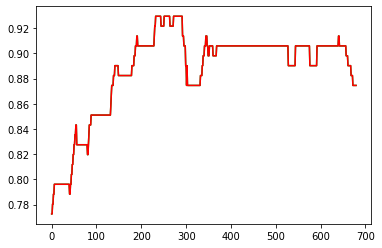

In [14]:
from matplotlib import pyplot as plt
%pylab inline

start = 0
end = result2.shape[2]

x = range(result2.shape[2])[start:end]
plt.plot(x, p[start:end], color='green', linestyle='solid')
plt.plot(x, myelu(c[start:end],-233), color='red', linestyle='solid')
# plt.plot(x, np.array(p)-np.array(c), color='blue', linestyle='solid')
plt.show()

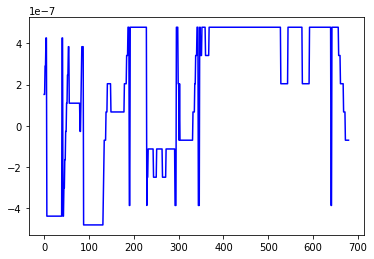

In [15]:
X = x[start:end]
Y = np.array(p)-np.array(c)
Y = Y[start:end]

plt.plot(X, Y, color='blue', linestyle='solid')
plt.show()